# Distance entre deux distributions

*Authors : Théo Duquesne, Taliesine Gueye, Navarre Victor et Benjamin Pineau*

On se demande si l'approche par des mélanges gaussien est pertinente. En outre, est ce que l'on peut approcher la distribution de nos données par des loi gaussiennes ? 

In [6]:
# Importation des bibliothèques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as rnd
from scipy.stats import norm
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from skimage import io
from PIL import Image
from io import BytesIO
import requests
from skimage.util import view_as_windows
from stepmix.stepmix import StepMix
from scipy.stats import wasserstein_distance
from scipy.stats import uniform

In [4]:
# Importation des données
star_data = pd.read_csv ('data_star.csv')
classes_categ = star_data['Star category'].unique()

# On manipule les données pour les utiliser dans le cadre d'un mélange gaussien
star_data.replace({'Spectral Class':{'M':0, 'A':1, 'B':2, 'F':1, 'O':2, 'K':0, 'G':1 }}, inplace = True)

star_data_model = star_data.drop(columns = ['Star type']) # pour avoir de la classification non supervisée
star_data_model['Star color'], _ = pd.factorize(star_data_model['Star color'])
star_data_model["Radius (R/Ro)"] = np.log(star_data_model["Radius (R/Ro)"])
star_data_model["Luminosity (L/Lo)"] = np.log(star_data_model["Luminosity (L/Lo)"])

/var/folders/vv/yd9tg_vd01b85m5mbpmc1v3r0000gn/T/ipykernel_24924/34632356.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  star_data.replace({'Spectral Class':{'M':0, 'A':1, 'B':2, 'F':1, 'O':2, 'K':0, 'G':1 }}, inplace = True)


On introduit la **distance de Wasserstein**, qui définit une distance entre des mesures de probabilité :

Soient $\mu$ et $\nu$ deux mesures de probabilités sur un espace $\mathcal{X}$. La distance de Wassertein est définie par
$$
W_p(\mu, \nu) = \bigg( \underset{\pi \in \Pi}{\text{inf}}\int_{\mathcal{X}\times \mathcal{X}}d(x, y)^p\text{d}\pi(x, y) \bigg)^{1/p}
$$

Plus la distance de Wasserstein est faible, plus les 2 distributions sont proches. On va utiliser cette distance entre la distribution de nos données et des gaussiennes. Plus précisémment, on récupère les moyennes $\mu_g$ et matrices de covariance $\Sigma_g$ obtenues avec un algotithme d'**Expextation Maximisation**, on construit une gaussienne $\mathcal{N}(\mu_g, \Sigma_g)$ et on calcule la distance de Wasserstein. 

On pourra alors savoir si l'approche par des mélanges gaussiens est pertinente

## Distance de Wasserstein entre une loi uniforme et une loi normale 

Distance de Wasserstein entre la loi uniforme et la loi gaussienne : 0.20869726106476666


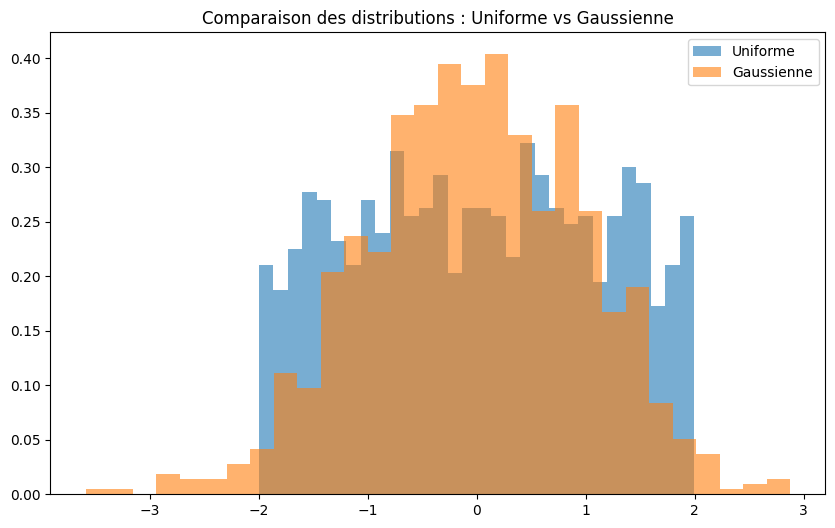

In [8]:
# Paramètres
n = 1000  # nombre d'échantillons
mean, std = 0, 1  # Moyenne et écart type pour la distribution gaussienne
low, high = -2, 2  # Limites pour la distribution uniforme

# Générer les échantillons
uniform_samples = uniform.rvs(loc=low, scale=high - low, size=n)
gaussian_samples = norm.rvs(loc=mean, scale=std, size=n)

# Calculer la distance de Wasserstein
distance = wasserstein_distance(uniform_samples, gaussian_samples)


print(f"Distance de Wasserstein entre la loi uniforme et la loi gaussienne : {distance}")

plt.figure(figsize=(10, 6))
plt.hist(uniform_samples, bins=30, alpha=0.6, label='Uniforme', density=True)
plt.hist(gaussian_samples, bins=30, alpha=0.6, label='Gaussienne', density=True)
plt.legend()
plt.title("Comparaison des distributions : Uniforme vs Gaussienne")
plt.show()


## Distance de Wasserstein entre un mélange gaussien et une loi normale 

/var/folders/vv/yd9tg_vd01b85m5mbpmc1v3r0000gn/T/ipykernel_24924/2620712759.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


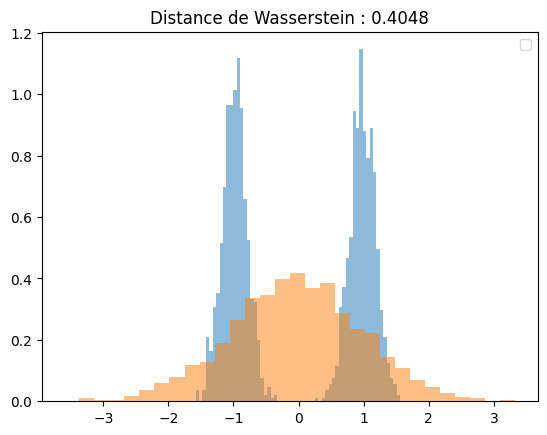

Distance de Wasserstein entre la mixture et la normale de comparaison : 0.4048


In [9]:
# Génération des deux gaussiennes séparées
n_samples = 1000

mu1, sigma1 = -5, 1 
mu2, sigma2 = 5, 1

data1 = np.random.normal(mu1, sigma1, n_samples)
data2 = np.random.normal(mu2, sigma2, n_samples)

# Créer une mixture de gaussiennes en les combinant
mixture_data = np.concatenate([data1, data2])
std = np.sqrt(np.var(mixture_data))
mixture_data = mixture_data/std

# Nouvelle distribution normale à comparer avec la mixture
mu_comparaison = (mu1 + mu2)/2 
sigma_comparaison = 1 
comparaison_data = np.random.normal(mu_comparaison, sigma_comparaison, len(mixture_data))

# Calcul de la distance de Wasserstein entre la mixture et la nouvelle normale
dist_w = wasserstein_distance(mixture_data, comparaison_data)

plt.hist(mixture_data, bins=60, alpha=0.5, density=True)
plt.hist(comparaison_data, bins=30, alpha=0.5, density=True)
plt.legend()
plt.title(f"Distance de Wasserstein : {dist_w:.4f}")
plt.show()

print(f"Distance de Wasserstein entre la mixture et la normale de comparaison : {dist_w:.4f}")

## Distance de Wassterstein entre nos données et une loi normale 

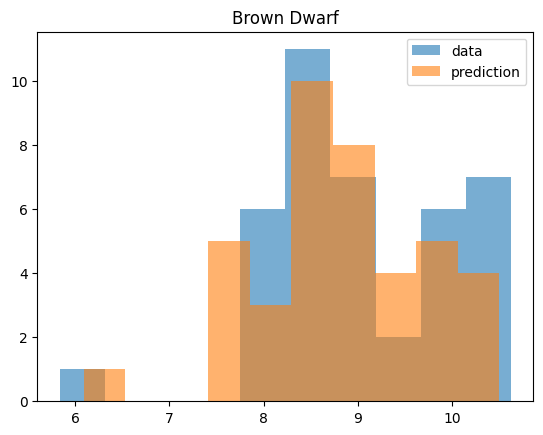

Pour : Brown Dwarf
Distance de Wasserstein: 0.1710


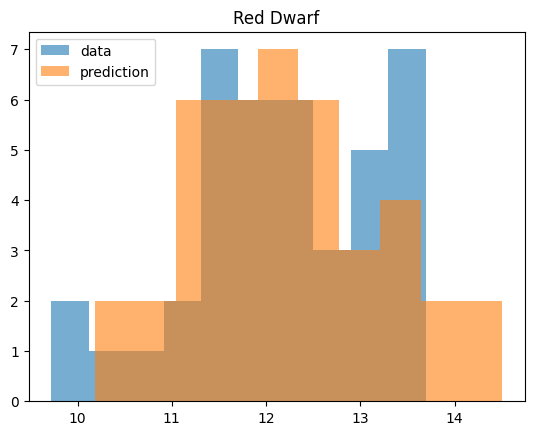

Pour : Red Dwarf
Distance de Wasserstein: 0.1176


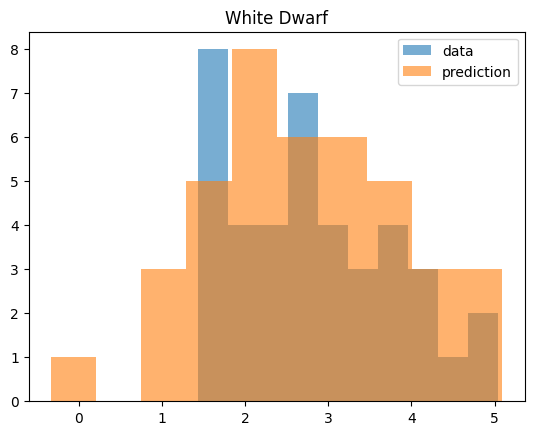

Pour : White Dwarf
Distance de Wasserstein: 0.3164


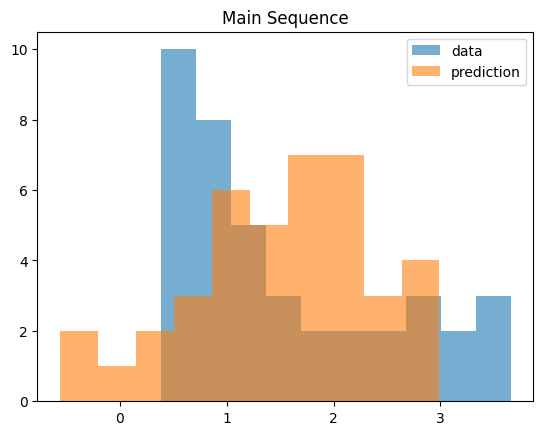

Pour : Main Sequence
Distance de Wasserstein: 0.3455


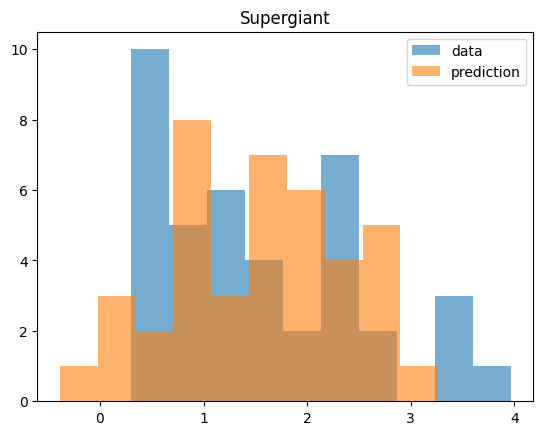

Pour : Supergiant
Distance de Wasserstein: 0.3307


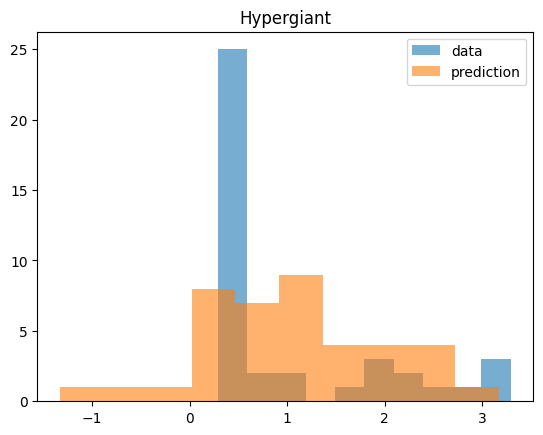

Pour : Hypergiant
Distance de Wasserstein: 0.3329


In [10]:
# On itère pour chaque classe d'étoile différentes
for categ in classes_categ:
    star_data_categ = star_data_model.loc[star_data_model['Star category'] == categ]
    star_data_categ = star_data_categ.drop(columns = ['Star category'])
    std_values = star_data_categ.std()
    std_values = std_values.replace(0, 1)
    star_data_categ = star_data_categ / std_values

    # On utilise l'algo EM sur la classe
    GMM_star_categ = GaussianMixture(n_components = 1, covariance_type='full', init_params = 'random_from_data')
    GMM_star_categ.fit(star_data_categ)

    # On récumère la moyenne et la matrice de covariance
    means = GMM_star_categ.means_
    covariances = GMM_star_categ.covariances_
    # On construit une loi normale
    normal_sample = np.random.multivariate_normal(means[0], covariances[0], len(star_data_categ))

    # On calcule la distance de Wasserstein entre la distribution des données et la loi normale
    wasserstein_distances = [
    wasserstein_distance(star_data_categ.iloc[:, i], normal_sample[:, i])
    for i in range(star_data_categ.shape[1])
    ]
    plt.hist(star_data_categ.iloc[:, 0], bins = 10, alpha = 0.6, label = 'data')
    plt.hist(normal_sample[:, 0], bins = 10, alpha = 0.6, label = 'prediction')
    plt.title(categ)
    plt.legend()
    plt.show()
    avg_wasserstein = np.mean(wasserstein_distances)
    print("Pour :", categ)
    print(f"Distance de Wasserstein: {avg_wasserstein:.4f}")



**Bilan** : il n'est pas forcément pertinent d'approcher nos distributions par des gaussiennes. Dans l'exemple si dessus, la loi gaussienne obtenue ne fit pas correctement la distribution des étoiles Hypergiantes. 